In [1]:
import os
import sys

sys.path.append('/global/project/projectdirs/desi/users/mjwilson/repos/desispec/py/desispec/radlss/')

In [2]:
# import jax

In [3]:
os.environ['PYTHONPATH'] = '/global/homes/m/mjwilson/.local/lib/python3.8/site-packages/corner/:' + os.environ['PYTHONPATH']

In [4]:
import time
import glob
import scipy
import corner
import fitsio

import itertools
import warnings

import numpy as np
import pylab as pl

import desisim.templates
import astropy.io.fits              as      fits

import desispec.io
import redrock.templates
import matplotlib.pyplot            as      plt

from   os                           import  path
from   astropy.convolution          import  convolve, Box1DKernel
from   desispec.spectra             import  Spectra
from   desispec.frame               import  Frame
from   desispec.resolution          import  Resolution
from   desispec.io.meta             import  findfile
from   desispec.io                  import  read_frame, read_fiberflat, read_flux_calibration, read_sky, read_fibermap
from   desispec.interpolation       import  resample_flux
from   astropy.table                import  Table
from   desispec.io.image            import  read_image
from   specter.psf.gausshermite     import  GaussHermitePSF
from   scipy.signal                 import  medfilt
from   desispec.calibfinder         import  CalibFinder
from   astropy.utils.exceptions     import  AstropyWarning
from   scipy                        import  stats
from   pathlib                      import  Path
from   templateSNR                  import  templateSNR
from   RadLSS                       import  RadLSS
from   scipy.optimize               import  Bounds

# Foundations to desispec ticket 1004:  Template SNR and LSS rad. weights.

Template SNR:

https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=4723;filename=sky-monitor-mc-study-v1.pdf;version=2

applied to SV0 dataset:

https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SV0

# Template SNR

$\Huge \langle tSNR^2 \rangle = \sum_{grz} \sum_{\lambda \in grz} \left ( \frac{\tau^2 T^2 \langle \Delta F^2 \rangle}{\sigma_e^2 \cdot {\rm NPIX/A} + \tau T_{\rm sky}  F_{\rm sky}} \right ) $

_"We choose to normalize it such that zSNR = 3 for a 1000 sec dark time exposure in
nominal conditions."_

Here:  
- $\sigma_e$ is the READNOISE in units of ELECTRONS / PIXEL. 
- NPIX/A is the projected fiber area in units of PIXELS for a width of **ONE ANGSTROM**.  
- $\Delta F$ is the residual (template) flux from a 100A filtered equivalent.
- $\tau$ is the exposure time, already included in the flux calib.
- $T_{\rm sky} F_{\rm sky}$ is the estimated fiber sky flux in units of ELECTRONS PER ANGSTROM.

In [5]:
def get_expids(night, andes='/global/cfs/cdirs/desi/spectro/redux/andes'):
    tiles  = np.unique(np.array([x.split('/')[-3] for x in glob.glob(andes + '/tiles/*/{}/cframe-*'.format(night))]).astype(np.int))

    # np.sort(np.array([x.split('/')[-1] for x in glob.glob(andes + '/exposures/{}/*'.format(night))]).astype(np.int))                                                                                  
    expids = np.unique(np.array([x.split('/')[-1].split('-')[2].replace('.fits','') for x in glob.glob(andes + '/tiles/*/{}/cframe-*'.format(night))]).astype(np.int))

    return  expids, tiles

In [6]:
nmax          = 1
night         = '20200315'
tracers       = ['ELG']

expids, tiles = get_expids(night)

cameras       = ['b5', 'r5', 'z5']

In [7]:
expids        = expids[1:2]

In [8]:
expids 

array([55589])

In [9]:
for nexp, expid in enumerate(expids):
    print('Solving for EXPID {:08d}'.format(expid))
    
    rads      = RadLSS(night, expid, cameras=cameras)
    
    rads.compute(tracers=tracers, templates=False)

    if nexp == nmax:
        break

Solving for EXPID 00055589
Rank 0:  Grabbing camera b5
Rank 0:  Grabbing camera r5
Rank 0:  Grabbing camera z5
Rank 0:  Retrieved pipeline data in 0.120 mins.
Rank 0:  Grabbing camera b5
Rank 0:  Grabbing camera r5
Rank 0:  Grabbing camera z5
Rank 0:  Retrieved pipeline data in 0.082 mins.
Rank 0:  Calculated NEA in 0.066 mins.
Rank 0:  Calculated psf-local readnoise in 0.123 mins.
DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift

In [18]:
zbest = Table.read(rads.data_zbest_file, 'ZBEST')

In [19]:
rr_z       = zbest['Z']

In [20]:
 spectype   = [x.strip() for x in zbest['SPECTYPE']]

In [21]:
subtype   = [x.strip() for x in zbest['SUBTYPE']]

In [22]:
fulltype   = list(zip(spectype, subtype))

In [26]:
ncoeff     = [rads.templates[ft].flux.shape[0] for ft in fulltype]

In [27]:
coeff      = [x[0:y] for (x,y) in zip(zbest['COEFF'], ncoeff)]

In [29]:
tfluxs     = [rads.templates[ft].flux.T.dot(cf).tolist()     for (ft, cf) in zip(fulltype, coeff)]

In [37]:
stfluxs    = [tfluxs[x] for x in rads.indx]

In [ ]:
rads.cframes['b5'].flux[np.argsort(rads.zbests_fib['5']['FIBER']), :]

         Current function value: 217.109665
         Iterations: 36
         Function evaluations: 659
         Gradient evaluations: 108
         Current function value: 315.783876
         Iterations: 93
         Function evaluations: 1353
         Gradient evaluations: 123
Rank 0:  Calculated line fluxes in 0.666 mins.


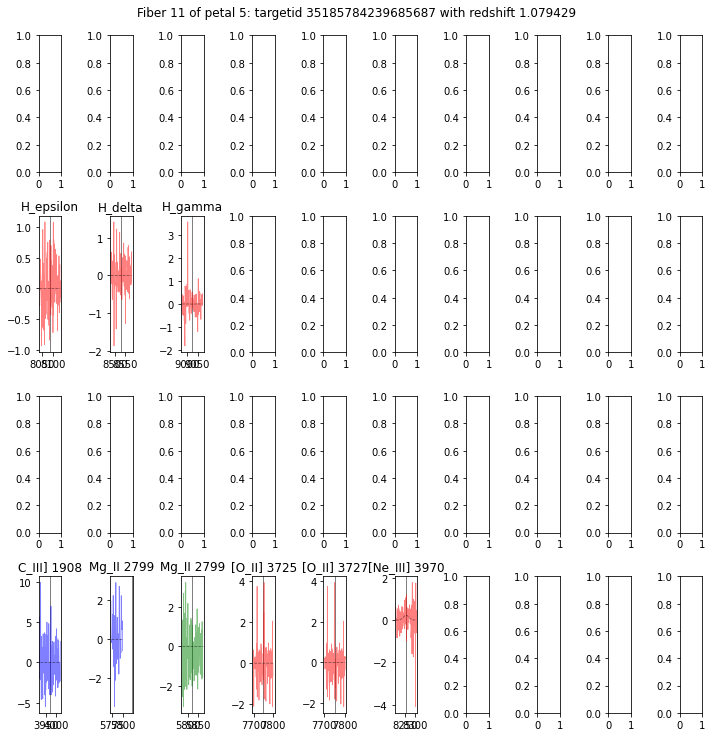

In [10]:
rads.line_fit(fiber=11)

(-0.5, 5.0)

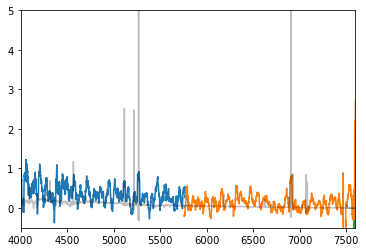

In [36]:
index = 11

for band in ['b', 'r', 'z']:
    pl.plot(rads.cframes['{}5'.format(band)].wave, convolve(rads.cframes['{}5'.format(band)].flux[index, :], Box1DKernel(30), boundary='extend'))
    pl.plot(rads.rr_cframes['{}5'.format(band)].wave, rads.rr_cframes['{}5'.format(band)].flux[index, :], c='k', alpha=0.25)
        
pl.xlim(4000., 7600.)
pl.ylim(-0.5, 5.)

In [39]:
rads.fibermaps['b5'][11]

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,NUMTARGET,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PHOTSYS,CMX_TARGET,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,DELTA_X,DELTA_Y,FIBER_RA,FIBER_DEC,TILEFIBERID,NEA,ANGSTROMPERPIXEL,CCDX,CCDY,RDNOISE,QUAD,RDNOISE_QUAD,TSNR,TSNR_SLESS,TSNR_RRSLESS,TSNR_MODELIVAR
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,uint8,str3,float32,float32,int16,int32,float64,int32,int64,int16,int32,str8,int32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,str1,int64,int64,int64,int64,float32,float32,float32,float32,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64
35185790279488323,5,102,5102,2511,0,138.8110976988429,1.3705442314419627,0.0,0.0,0.0,0.0,0.0,5400.0,2048,1,TGT,45.48196,195.76076,0,10000,0.430852305245929,65535,100,8000,338123,1388p012,4931,REX,2146027900.0,2199195400.0,0.031845327,0.29927525,0.25617328,0.3003027,1303.0236,299.35632,49.027134,0.91003823,0.93847334,0.96510404,0.43096584,0.4770163,0.56422555,0.011696196,0.008612545,0.01328212,0.99989814,0.9998599,0.9997762,4,3,3,2216.0515,592.0405,87.86843,1309.7261,293.05807,47.49054,0.59907204,-4.1531606,81.02689,-206.26677,2.4867563,0.47601676,0.000798042,1.0462741e-05,0.9946177,0.9966911,0.9992934,0.99973315,0,0,0,0.16730398,0.14320867,0.16787837,0.17858624,0.15952821,0.18732002,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.43047324,0.0,0.0,182.28758,0.0,0.0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,True,0.0,0.0,S,2048,3000,1,27309,0.0,0.0,0.0,0.0,0,0,0,3,45.435,195.658,0.002,-0.001,0.0,0.0,672302511,14.786461614833225,0.5964385700751212,209.11205404720963,1911.5133807049363,3.9413963556289673,A,3.943477957050238,87.71103051708091,124.98624376790707,116.02522753008031,52.87477096386773


In [40]:
tid = 35185790279488323

In [41]:
rads.zbests['5'][rads.zbests['5']['TARGETID'] == tid]

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE
int64,float64,float64,float64,float64,int64,int64,bytes6,bytes20,int64,float64,int32,int32
35185790279488323,12391.790185302496,293.3894105178371 .. 15.73074219736955,0.05205255687520906,3.518111832553649e-06,0,7927,GALAXY,,10,1674.342764288187,0,1


In [22]:
from lines import lines

In [42]:
3889 * (1. + 0.05)

4083.4500000000003

In [13]:
rads.zbests_fib['5'] = Table.read(rads.data_zbest_file, 'FIBERMAP')

In [15]:
rads.zbests_fib['5'] = rads.zbests_fib['5'][rads.zbests_fib['5']['EXPID'] == rads.expid]

In [16]:
rads.zbests_fib['5'].sort('TARGETID')

In [37]:
rads.zbests['5']['DELTACHI2']

34.98541857302189
33.35675486922264
1954.7615637164563
533.7973711490631
2.505560301244259
574.3106331080198
0.17507775127887726
103443.48394789209
88.6074578166008
264.86041563749313
5.248475730419159


In [44]:
rads.zbests_fib['5']['FIBER'][5] - 2500

327

In [11]:
# ! ls /global/cscratch1/sd/mjwilson/radlss/test//ensemble/

In [12]:
# sample             = rads.ensemble_meta['ELG']['REDSHIFT', 'MAG_G', 'MAG_R', 'MAG_Z', 'OIIFLUX']
# sample['OIIFLUX'] *= 1.e17
# sample['r-z']      = sample['MAG_R'] - sample['MAG_Z'] 
# sample['g-r']      = sample['MAG_G'] - sample['MAG_R'] 

# del sample['MAG_G']
# del sample['MAG_R']
# del sample['MAG_Z']

# sample

In [13]:
# ndim, nsamples = 5, len(sample)

# data_kwargs    = {'markersize': 2, 'alpha': 1.0}

# figure         = corner.corner(np.array(np.array(sample).tolist()), labels=sample.dtype.names,
#                                quantiles=[0.16, 0.5, 0.84], plot_contours=False,
#                                show_titles=True, title_kwargs={"fontsize": 12},
#                                plot_datapoints=True, plot_density=False, no_fill_contours=True, data_kwargs=data_kwargs)

In [10]:
def X2(params, z, wave, Res, flux, continuum, linea, lineb, twave):
    [lnline_flux, r, sigma]         = params
    Rflux, X2, line_flux            = line_fit(z, wave, Res, flux, continuum, sigma, r, np.exp(lnline_flux), linea, lineb, twave)
    
    return  X2

In [12]:
index                               =  404
petal                               = '5'
band                                = 'r'
  
# zz                                = rads.zbests[petal]['Z'][index]
# oii_truth                         = rads.ensemble_objmeta['ELG']['OIIFLUX'][index] 

wave                                = rads.cframes['{}5'.format(band)].wave
flux                                = rads.cframes['{}5'.format(band)].flux[index,:]
ivar                                = rads.cframes['{}5'.format(band)].ivar[index,:]

Res                                 = Resolution(rads.cframes['{}5'.format(band)].resolution_data[index])

zz                                  = rads.ensemble_meta['ELG']['REDSHIFT'][index]
zerr                                = 1.e-2
flux                                = rads.ensemble_flux['ELG'][band][index]

twave                               = np.arange(3100., 10400., 0.1)

In [13]:
window                              = np.arange((3727. * (1. + zz)) - 50., (3727. * (1. + zz)) + 50., 0.8)
xmin, xmax                          = window.min(), window.max()

continuum                           = ((wave > window.min()) & (wave < window.max())) & ((wave < (window.min() + 20.)) | (wave > (window.max() - 20.)))
continuum                           = np.median(flux[continuum])

flux                                = np.array(flux, copy=True)
flux                               -= continuum

(-0.5, 2.8757993668317794)

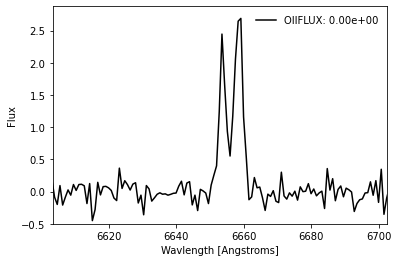

In [14]:
pl.plot(wave, flux,  c='k', label='OIIFLUX: {:.2e}'.format(0.0))
pl.legend(frameon=False)

pl.xlabel('Wavlength [Angstroms]')
pl.ylabel('Flux')

pl.xlim(xmin, xmax)
pl.ylim(bottom=-0.5)

In [27]:
linea                               = 3727.092
lineb                               = 3729.875

In [28]:
args                                = (zz, wave, Res, flux, 0.0, 3727.092, 3729.875, twave)

In [29]:
# bounds                            = Bounds([0.0, 0.0, 0.0], [50., 1.0, 100.])

In [32]:
# lnline_flux, r, sigma
x0                                  = np.array([np.log(5.), 0.7, 15.])
result                              = scipy.optimize.minimize(X2, x0, args, method='CG')
[lnline_flux, r, sigma]             = result.x

In [33]:
lnline_flux, r, sigma

(2.6561889526370472, 0.7190404080093783, 41.93802194863647)

In [34]:
Rflux, _, _  = line_fit(zz, wave, Res, flux, sigma=sigma, r=r, line_flux=np.exp(line_flux))

(-0.5, 3.046496071777168)

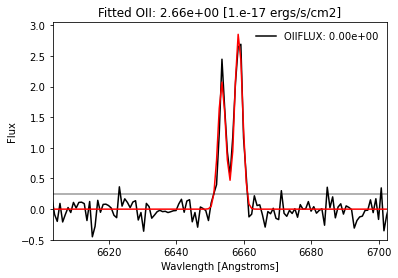

In [35]:
pl.plot(wave, flux,  c='k', label='OIIFLUX: {:.2e}'.format(0.0))
pl.plot(wave, Rflux, c='r')

pl.axhline(continuum, alpha=0.4, c='k')

pl.legend(frameon=False)

pl.title('Fitted OII: {:.2e} [1.e-17 ergs/s/cm2]'.format(line_flux))

pl.xlabel('Wavlength [Angstroms]')
pl.ylabel('Flux')

pl.xlim(xmin, xmax)
pl.ylim(bottom=-0.5)

In [36]:
result

     fun: 172.7775051520718
     jac: array([0.00000000e+00, 0.00000000e+00, 7.62939453e-06])
 message: 'Optimization terminated successfully.'
    nfev: 264
     nit: 29
    njev: 66
  status: 0
 success: True
       x: array([ 2.65618895,  0.71904041, 41.93802195])

In [37]:
import scipy

from   scipy             import optimize
from   scipy.optimize    import approx_fprime, minimize, Bounds
from   scipy.stats       import multivariate_normal

In [49]:
def X2(x):  
  z         = x[0]
  v         = x[1]
  r         = x[2] 
  lnA       = x[3]
    
  line_flux = np.exp(lnA)
    
  Rflux, X2, _  = line_fit(z, wave, Res, flux, sigma=v, r=r, line_flux=line_flux)
    
  return  X2

In [56]:
mloglike([zz, 30., 0.8, 2.0])

-94.98079476226442

In [58]:
mloglike([zz, 150., 0.8, 2.0])

-108.24173430154636

In [59]:
def mloglike(x):
    return X2(x) / 2.

In [60]:
def mlogpos(x):
    return mloglike(x) + mlogprior(x)

In [61]:
def gradient(x):
  eps = 1.e-8
    
  return optimize.approx_fprime(x, mlogpos, eps)

In [62]:
# [z, v, r, A]
oo     = np.array([zz, 28., 0.7, 3.08])

In [63]:
zz

0.7851922191932855

In [64]:
mlogpos([0.78, 28., 0.7, 3.08])

250.22796236009427

In [65]:
mlogpos([0.78, 28., 0.7, 2.08])

147.22100982507726

In [66]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_bfgs.html
result = scipy.optimize.fmin_bfgs(mlogpos, oo, fprime=gradient, gtol=1e-05, norm=-np.inf, epsilon=1.4901161193847656e-08, maxiter=None, full_output=True, disp=1, retall=1, callback=None)

Optimization terminated successfully.
         Current function value: 88.297499
         Iterations: 22
         Function evaluations: 37
         Gradient evaluations: 28


In [67]:
# Parameters which minimize f, i.e., f(xopt) == fopt.
# Minimum value.
# Value of gradient at minimum, fprime(xopt), which should be near 0.
# Value of 1/fdoubleprime(xopt), i.e., the inverse Hessian matrix.
# Number of function_calls made.
# Number of gradient calls made.
# Maximum number of iterations exceeded. 2 : Gradient and/or function calls not changing. 3 : NaN result encountered. 
# The value of xopt at each iteration. Only returned if retall is True.
result[0]

array([ 0.78521647, 40.21359148,  0.71664804,  2.62414942])

In [68]:
result[1]

88.29749908675814

In [69]:
Rflux, _, _  = line_fit(result[0][0], wave, Res, flux, sigma=result[0][1], r=result[0][2], line_flux=np.exp(result[0][3]))
# Rflux, _, _  = line_fit(zz, wave, Res, flux, sigma=50., r=0.8, line_flux=np.exp(2.))

(-0.5, 3.0)

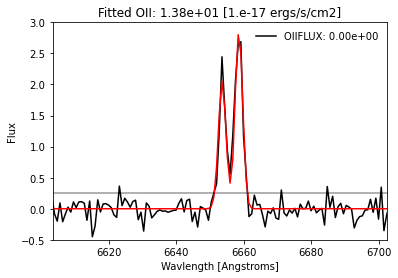

In [70]:
pl.plot(wave, flux,  c='k', label='OIIFLUX: {:.2e}'.format(0.0))
pl.plot(wave, Rflux, c='r')

pl.axhline(continuum, alpha=0.4, c='k')

pl.legend(frameon=False)

pl.title('Fitted OII: {:.2e} [1.e-17 ergs/s/cm2]'.format(np.exp(result[0][3])))

pl.xlabel('Wavlength [Angstroms]')
pl.ylabel('Flux')

pl.xlim(xmin, xmax)
pl.ylim(bottom=-0.5, top=3.0)

In [71]:
ihess = result[3]

In [72]:
for x in ihess:
    print(x)

[ 1.23429295e-09 -5.02341168e-05  7.91233469e-07  3.76546810e-08]
[-5.02341168e-05  9.03815367e+01 -1.34391154e-01  6.21418904e-01]
[ 7.91233469e-07 -1.34391154e-01  1.95511160e-02  1.23341680e-03]
[3.76546810e-08 6.21418904e-01 1.23341680e-03 1.56440221e-02]


In [75]:
# [z, v, r, A]
result[0]

array([ 0.78521647, 40.21359148,  0.71664804,  2.62414942])

In [76]:
# https://astrostatistics.psu.edu/su11scma5/HeavensLecturesSCMAVfull.pdf
# Note:  marginal errors.
merr = np.sqrt(np.diag(ihess))
merr

array([3.51325056e-05, 9.50692046e+00, 1.39825305e-01, 1.25076065e-01])

In [77]:
samples             = np.random.multivariate_normal(mean=result[0], cov=result[3], size=50000)

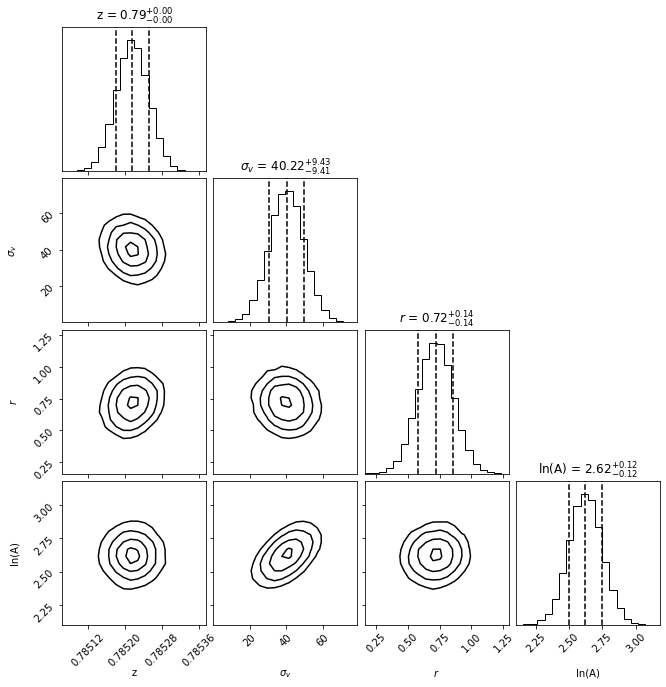

In [78]:
ndim, nsamples      = 4, len(samples)
data_kwargs         = {'markersize': 2, 'alpha': 1.0}

figure              = corner.corner(samples, labels=['z', r'$\sigma_v$', '$r$', 'ln(A)'],
                                    quantiles=[0.16, 0.5, 0.84], plot_contours=True,
                                    show_titles=True, title_kwargs={"fontsize": 12},
                                    plot_datapoints=False, plot_density=False, no_fill_contours=False, data_kwargs=data_kwargs)

In [1213]:
import jax.numpy      as     jnp
 
from   jax            import hessian, grad
from   scipy.stats    import multivariate_normal
from   scipy.optimize import minimize

In [1214]:
sigma     = jnp.array([(1.0, 0.5), (0.5, 1.0)])
mu        = jnp.array([0.5, 2.0])
nu        = jnp.array([7])

sigma_inv = jnp.linalg.inv(sigma)

In [1215]:
def negative_log_posterior(theta):
    return (-jnp.log(
        1.0 + nu ** -1.0 * jnp.dot((theta - mu), jnp.dot(sigma_inv, (theta - mu).T).T)
    ) * (0.5  * -(nu + theta.shape[0])))[0]

In [1216]:
def grad_negative_log_posterior(theta):
    return grad(negative_log_posterior)(theta)

In [1217]:
def approx_covariance_matrix(theta):
    return jnp.linalg.inv(hessian(negative_log_posterior)(theta))

In [1219]:
theta_star = minimize(
    negative_log_posterior, 
    jnp.array([0.0, 0.0]), 
    jac=grad_negative_log_posterior, 
    method="BFGS"
).x

In [1220]:
theta_star

array([0.49996502, 2.0000122 ])

In [1223]:
sigma_approx = sigma_approx = approx_covariance_matrix(theta_star)
sigma_approx

DeviceArray([[0.77777773, 0.38888887],
             [0.38888887, 0.77777773]], dtype=float32)

In [1225]:
mu

DeviceArray([0.5, 2. ], dtype=float32)

In [1224]:
sigma

DeviceArray([[1. , 0.5],
             [0.5, 1. ]], dtype=float32)

# Done.